In [2]:
import os
import numpy as np
import pandas as pd
from pyimzml.ImzMLParser import ImzMLParser
from tqdm.notebook import tqdm

In [3]:
# Define folder that contains the preprocessed dhg dataset
DHG_IN_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Preprocessed"
# Define file to export
META_DATA_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Preprocessed/Metadata.csv"
meta_data = pd.read_csv(META_DATA_PATH)

In [4]:
meta_data_s = meta_data[meta_data.file_name.str.contains('s')]

In [5]:
meta_data_s.groupby(['file_name']).size().sort_values()

file_name
HG 5-s        519
HG 6-s        608
HG 9-s        623
HG 7-s        628
HG 2-s        673
HG 19-s       680
HG 11_1-s     755
HG 4-s        832
HG 10-s       887
HG 3-s        947
HG 18-s       972
HG 11_2-s     974
HG 15-s      1160
HG 13-s      1177
HG 25-s      1199
HG 12-s      1278
HG 16-s      1300
HG 20-s      1347
HG 12_1-s    1355
HG 23-s      1576
HG 21-s      1586
HG 14-s      1946
HG 8-s       2096
HG 29-s      2252
dtype: int64

In [6]:
meta_data_s.groupby(['file_name']).size().sum()

27370

In [7]:
exclude_sample = meta_data_s.file_name[0]
exclude_sample

'HG 10-s'

In [7]:
meta_data_s_train = meta_data_s[meta_data_s.file_name != exclude_sample]
meta_data_s_train.shape

(26483, 11)

In [8]:
meta_data_s_test = meta_data_s[meta_data_s.file_name == exclude_sample]
meta_data_s_test.shape

(887, 11)

In [8]:
parsers = { file_name: ImzMLParser(os.path.join(DHG_IN_PATH, f"{file_name}.imzML")) for file_name in meta_data_s.file_name.unique()}

In [10]:
intensities_train = meta_data_s_train.apply(lambda row: parsers[row.file_name].getspectrum(row.idx)[1], axis=1)

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(512, activation="relu", input_shape=(92000,)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(4, activation='softmax'),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

model.fit(np.array(intensities.tolist()), meta_data_s_train[["who_grade_1", "who_grade_2", "who_grade_3","who_grade_4"]].to_numpy(), epochs=10)

2022-04-21 16:21:24.416023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 16:21:24.416064: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-21 16:21:33.763614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:21:33.763649: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:21:33.763674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dt-cpu-02): /proc/driver/nvidia/version does not exist
2022-04-21 16:21:33.764021: I tensorflow/core/platform/cpu_feature_

NameError: name 'intensities' is not defined

In [45]:
import gc
gc.collect()

1540

In [14]:
intensities_test = meta_data_s_test.apply(lambda row: parsers[row.file_name].getspectrum(row.idx)[1], axis=1)

In [37]:
model.evaluate(np.array(intensities.tolist()), meta_data_s_train[["who_grade_1", "who_grade_2", "who_grade_3","who_grade_4"]].to_numpy())

828/828 [==============================] - 40s 48ms/step - loss: 0.0012 - accuracy: 0.9997


[0.001191059942357242, 0.9996601343154907]

NameError: name 'plt' is not defined

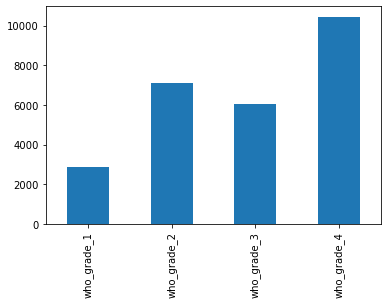

In [36]:
meta_data_s_train[["who_grade_1", "who_grade_2", "who_grade_3","who_grade_4"]].sum().plot(kind="bar")

In [27]:
meta_data_s_train.who_grade_1.sum()

2876

In [28]:
meta_data_s_train.who_grade_2.sum()

7123

In [30]:
meta_data_s_train.who_grade_3.sum()

6034

In [31]:
meta_data_s_train.who_grade_4.sum()

10450

In [10]:
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = layers.Input(shape=(92000,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(92000, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# intermediate result
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
intensities = meta_data_s.apply(lambda row: parsers[row.file_name].getspectrum(row.idx)[1], axis=1)

In [ ]:
autoencoder.fit(np.array(intensities.tolist()), np.array(intensities.tolist()),
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.6931